# SNN Conversion
We now want to convert our trained ANN network into an SNN network.

For this we can load our pretrained ANN and convert it using SINABS.

In [1]:
import torch
import torch.nn as nn
import sinabs
import sinabs.layers as sl
import pandas as pd
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt# Calculate MSE for all result dfs
from sklearn.metrics import mean_squared_error
# Calculate R2 for all result dfs
from sklearn.metrics import r2_score

In [2]:
# Model definition

ann = nn.Sequential(
    nn.Linear(3, 256),  # Input layer: 3 features (mu, sigma, x)
    nn.ReLU(),
    #nn.Dropout(0.2),
    nn.Linear(256, 256),  # first hidden layer
    nn.ReLU(),
    #nn.Dropout(0.2),
    nn.Linear(256, 256),  # second hidden layer
    nn.ReLU(),
    #nn.Dropout(0.2),
    nn.Linear(256, 1)    # Output layer: single value for f(x; mu, sigma)
)

In [3]:
ann.load_state_dict(torch.load("./results/2x256hidden_SGD_train_data_final/ann_epoch_499.pth"))

<All keys matched successfully>

In [4]:
# Convert to SNN
num_time_steps_per_sample = 100

snn_lin_out = sinabs.from_model(ann, input_shape=(3,), add_spiking_output=False, synops=False, num_timesteps=num_time_steps_per_sample)

In [5]:
snn_lin_out

Network(
  (spiking_model): Sequential(
    (0): Linear(in_features=3, out_features=256, bias=True)
    (1): IAFSqueeze(spike_threshold=Parameter containing:
    tensor(1.), min_v_mem=Parameter containing:
    tensor(-1.), batch_size=-1, num_timesteps=100)
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): IAFSqueeze(spike_threshold=Parameter containing:
    tensor(1.), min_v_mem=Parameter containing:
    tensor(-1.), batch_size=-1, num_timesteps=100)
    (4): Linear(in_features=256, out_features=256, bias=True)
    (5): IAFSqueeze(spike_threshold=Parameter containing:
    tensor(1.), min_v_mem=Parameter containing:
    tensor(-1.), batch_size=-1, num_timesteps=100)
    (6): Linear(in_features=256, out_features=1, bias=True)
  )
  (analog_model): Sequential(
    (0): Linear(in_features=3, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=256, bias=T

We can see that the transformation replaced all ReLU() Activation functions with an IAFSqueeze Layer and added a spike_output layer of the same name.

We now need to test how the results compare with this transformed model.

In [6]:
# Get Test Dataset

# Load test dataset
test_df = pd.read_csv('./data_generation/test_data_min_max_input_half_lin_half_normal.csv')

In [7]:
class DataFrameDataset(torch.utils.data.Dataset):
    def __init__(self, dataframe, is_spiking=False, timesteps=100):
        self.timesteps = timesteps
        self.is_spiking = is_spiking
        self.inputval = torch.Tensor(dataframe["Series1"])
        self.mean = torch.Tensor(dataframe["Series2"])
        self.std = torch.Tensor(dataframe["Series3"])
        self.features = torch.stack([self.inputval, self.mean, self.std], dim=1)
        self.labels = torch.Tensor(dataframe["Label"])

    def __len__(self):
        return len(self.inputval)

    def __getitem__(self, idx):
        feature = self.features[idx]        
        labels = self.labels[idx]
        
        # Repeat for timesteps
        if self.is_spiking:
            feature = feature.repeat(self.timesteps, 1)
            labels = labels.repeat(self.timesteps, 1)
        
        return feature, labels
    
test_dataset = DataFrameDataset(test_df, is_spiking=True, timesteps=num_time_steps_per_sample)

In [8]:
feature, label = test_dataset[0]
feature.shape

torch.Size([100, 3])

In [9]:
label.shape

torch.Size([100, 1])

In [10]:
BATCH_SIZE = 1024

dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [ ]:
# Try to run a batch
def eval_loop(dataloader, model, mode="mean", apply_from=0, is_norse=False):
    results = []

    for data, target in tqdm(dataloader):
        data, target = data.to("cpu"), target.to("cpu")
        # prepare data
        data = torch.swapaxes(input=data, axis0=0, axis1=1)
        target = torch.swapaxes(input=target, axis0=0, axis1=1)
        print(data)
        print(data.shape)
        

        with torch.no_grad():
            output = model(data)
            if is_norse:
                print(f"Data shape: {data.shape}")
                output = output[0]
                print(output.shape)
            for i in range(BATCH_SIZE):
                try:
                    if not is_norse:
                        if mode == "mean":
                            results.append((target[0, i, :].item(), output[apply_from:, i, :].mean().item()))
                        elif mode == "count":
                            results.append((target[0, i, :].item(), (output[apply_from:, i, :] > 0).sum().item()))
                        elif mode == "last":
                            results.append((target[0, i, :].item(), output[-1, i, :].item()))
                    else:
                        if mode == "mean":
                            results.append((target[0, i, :].item(), output[apply_from:, i, :].mean().item(), output))
                        elif mode == "count":
                            results.append((target[0, i, :].item(), (output[apply_from:, i, :] > 0).sum().item(), output))
                except Exception:
                    break
                
    return results

results = eval_loop(dataloader, snn_lin_out)
results_last = eval_loop(dataloader, snn_lin_out, mode="last")

  0%|          | 0/196 [00:00<?, ?it/s]

tensor([[[ 9.1683,  3.0781,  4.5969],
         [-1.0357, -2.6973,  6.2832],
         [ 7.7578,  0.4125,  4.5344],
         ...,
         [-4.9368, -2.8877,  1.0993],
         [-1.1176, -1.0472,  0.4747],
         [14.8104, -1.4915,  3.0979]],

        [[ 9.1683,  3.0781,  4.5969],
         [-1.0357, -2.6973,  6.2832],
         [ 7.7578,  0.4125,  4.5344],
         ...,
         [-4.9368, -2.8877,  1.0993],
         [-1.1176, -1.0472,  0.4747],
         [14.8104, -1.4915,  3.0979]],

        [[ 9.1683,  3.0781,  4.5969],
         [-1.0357, -2.6973,  6.2832],
         [ 7.7578,  0.4125,  4.5344],
         ...,
         [-4.9368, -2.8877,  1.0993],
         [-1.1176, -1.0472,  0.4747],
         [14.8104, -1.4915,  3.0979]],

        ...,

        [[ 9.1683,  3.0781,  4.5969],
         [-1.0357, -2.6973,  6.2832],
         [ 7.7578,  0.4125,  4.5344],
         ...,
         [-4.9368, -2.8877,  1.0993],
         [-1.1176, -1.0472,  0.4747],
         [14.8104, -1.4915,  3.0979]],

        [[

In [13]:
# Transform  results to dataframe
results_df = pd.DataFrame(results, columns=["target", "output"])
results_last_df = pd.DataFrame(results_last, columns=["target", "output"])

# Add absolute diff
results_df["abs_diff"] = abs(results_df["target"] - results_df["output"])
results_last_df["abs_diff"] = abs(results_last_df["target"] - results_last_df["output"])

results_df.head()

,target,output,abs_diff
0,0.036083,0.034253,0.001830
1,0.061312,0.057514,0.003798
2,0.023691,0.024116,0.000425
3,0.622410,0.595233,0.027177
4,0.116947,0.107520,0.009427


In [14]:
results_df.describe()

,target,output,abs_diff
count,2.000000e+05,200000.000000,2.000000e+05
mean,1.086131e-01,0.099475,1.119742e-02
std,3.001227e-01,0.270477,3.334998e-02
min,0.000000e+00,-0.011988,7.450581e-09
25%,2.247868e-08,0.001744,1.304973e-03
50%,3.664592e-02,0.033618,3.161420e-03
75%,9.494516e-02,0.088601,8.664416e-03
max,3.989422e+00,4.088102,6.983721e-01


In [15]:
results_last_df.describe()

,target,output,abs_diff
count,2.000000e+05,200000.000000,2.000000e+05
mean,1.086131e-01,0.108865,1.544248e-01
std,3.001227e-01,0.400087,2.122011e-01
min,0.000000e+00,-0.877870,2.644956e-07
25%,2.247868e-08,-0.053572,4.459906e-02
50%,3.664592e-02,0.038193,9.913495e-02
75%,9.494516e-02,0.165465,1.948223e-01
max,3.989422e+00,11.021291,7.107437e+00


In [16]:
print(f"MSE: {mean_squared_error(results_df['target'], results_df['output'])}")
print(f"R2: {r2_score(results_df['target'], results_df['output'])}")
print(f"MSE: {mean_squared_error(results_last_df['target'], results_last_df['output'])}")
print(f"R2: {r2_score(results_last_df['target'], results_last_df['output'])}")


MSE: 0.0012375979823318224
R2: 0.9862600818103111
MSE: 0.06887610804800827
R2: 0.23533158318444236


(array([1.4031e+05, 2.8854e+04, 9.9680e+03, 5.1160e+03, 3.0640e+03,
        2.2150e+03, 1.6400e+03, 1.3730e+03, 1.0240e+03, 8.5200e+02,
        6.5000e+02, 5.8000e+02, 4.5500e+02, 3.9900e+02, 3.5800e+02,
        2.7800e+02, 2.5800e+02, 1.9200e+02, 1.7300e+02, 1.8800e+02,
        1.3800e+02, 1.2200e+02, 1.0400e+02, 9.9000e+01, 1.0800e+02,
        1.0100e+02, 8.5000e+01, 8.7000e+01, 5.8000e+01, 8.9000e+01,
        6.3000e+01, 5.0000e+01, 3.7000e+01, 4.7000e+01, 3.3000e+01,
        3.4000e+01, 3.8000e+01, 4.1000e+01, 3.4000e+01, 4.4000e+01,
        2.7000e+01, 3.4000e+01, 2.3000e+01, 1.7000e+01, 1.7000e+01,
        1.6000e+01, 1.3000e+01, 1.6000e+01, 1.3000e+01, 1.2000e+01,
        1.1000e+01, 1.5000e+01, 1.4000e+01, 9.0000e+00, 1.3000e+01,
        1.0000e+01, 1.0000e+01, 8.0000e+00, 1.1000e+01, 6.0000e+00,
        1.2000e+01, 1.2000e+01, 1.6000e+01, 1.2000e+01, 1.6000e+01,
        2.0000e+01, 9.0000e+00, 1.3000e+01, 1.6000e+01, 8.0000e+00,
        9.0000e+00, 1.0000e+01, 1.1000e+01, 1.40

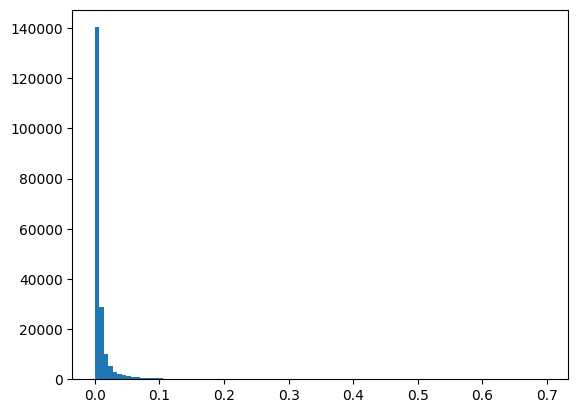

In [17]:
# Plot abs_diff
plt.hist(results_df["abs_diff"], bins=100)

            target       output     abs_diff
count  3374.000000  3374.000000  3374.000000
mean      1.843503     1.638002     0.208898
std       0.963844     0.868276     0.126587
min       0.019869     0.120148     0.100012
25%       1.120344     0.993782     0.121514
50%       1.588937     1.408489     0.160846
75%       2.384758     2.151169     0.242184
max       3.989422     4.088102     0.698372


(array([  1.,   0.,   0.,   0.,   0.,   4.,   2.,   1.,   3.,   3.,   6.,
         12.,  14.,  26.,  20.,  23.,  20.,  26.,  44.,  54.,  85.,  57.,
         60., 102.,  54.,  63.,  70., 147., 114.,  49.,  48.,  63., 103.,
        109., 144.,  27.,  31.,  37.,  37.,  57.,  60.,  70.,  75., 142.,
         88.,  21.,  19.,  12.,  22.,  18.,  20.,  16.,  17.,  19.,  29.,
         38.,  38.,  38.,  40.,  57.,  71.,  99.,   3.,   7.,   7.,   8.,
          7.,   9.,   6.,   6.,  11.,  11.,   8.,   8.,   9.,   9.,  10.,
         12.,  14.,  12.,  16.,  12.,  16.,   9.,  12.,  12.,  20.,  12.,
         11.,  20.,  23.,  18.,  17.,  24.,  37.,  26.,  25.,  29.,  36.,
        117.]),
 array([0.01986901, 0.05956454, 0.09926007, 0.1389556 , 0.17865113,
        0.21834666, 0.25804219, 0.29773772, 0.33743325, 0.37712879,
        0.41682432, 0.45651985, 0.49621538, 0.53591091, 0.57560644,
        0.61530197, 0.6549975 , 0.69469303, 0.73438856, 0.77408409,
        0.81377962, 0.85347515, 0.89317069, 0.

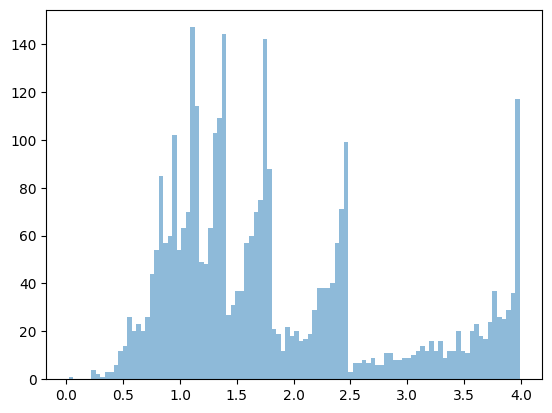

In [18]:
# Get the ones where abs_diff is greater than 0.1
print(results_df[results_df["abs_diff"] > 0.1].describe())

# Plot the targets and outputs for this subset
plt.hist(results_df[results_df["abs_diff"] > 0.1]["target"], bins=100, alpha=0.5, label="target")

             target         output      abs_diff
count  1.966260e+05  196626.000000  1.966260e+05
mean   7.884327e-02       0.073075  7.804983e-03
std    1.521479e-01       0.142006  1.319924e-02
min    0.000000e+00      -0.011988  7.450581e-09
25%    1.335588e-08       0.001695  1.282612e-03
50%    3.402108e-02       0.031364  3.072589e-03
75%    9.073821e-02       0.084793  8.184169e-03
max    3.988767e+00       4.024276  9.999454e-02


(array([1.02196e+05, 3.71410e+04, 2.17900e+04, 1.03460e+04, 6.19200e+03,
        4.02200e+03, 2.72700e+03, 2.08300e+03, 1.66200e+03, 1.27700e+03,
        1.22200e+03, 8.47000e+02, 7.42000e+02, 6.47000e+02, 4.81000e+02,
        4.63000e+02, 4.45000e+02, 2.78000e+02, 3.59000e+02, 1.64000e+02,
        2.83000e+02, 1.95000e+02, 1.24000e+02, 1.50000e+02, 1.42000e+02,
        4.90000e+01, 5.80000e+01, 5.80000e+01, 8.10000e+01, 1.80000e+01,
        2.80000e+01, 2.60000e+01, 2.70000e+01, 1.80000e+01, 3.60000e+01,
        1.00000e+01, 1.20000e+01, 1.20000e+01, 1.00000e+01, 1.20000e+01,
        8.00000e+00, 1.60000e+01, 1.10000e+01, 9.00000e+00, 1.10000e+01,
        7.00000e+00, 4.00000e+00, 3.00000e+00, 6.00000e+00, 4.00000e+00,
        1.00000e+01, 6.00000e+00, 1.00000e+01, 3.00000e+00, 5.00000e+00,
        3.00000e+00, 4.00000e+00, 8.00000e+00, 4.00000e+00, 4.00000e+00,
        4.00000e+00, 7.00000e+00, 5.00000e+00, 4.00000e+00, 1.00000e+00,
        4.00000e+00, 4.00000e+00, 6.00000e+00, 1.00

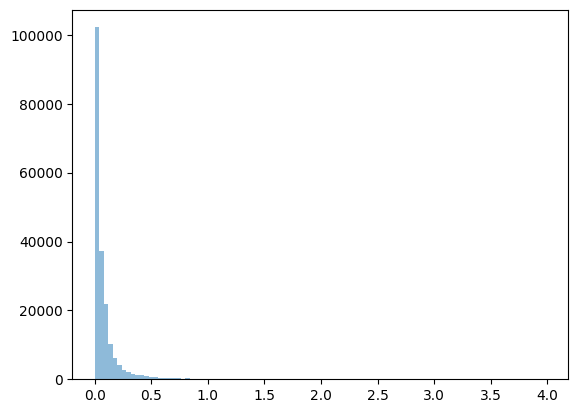

In [19]:
# Plot hist for the ones with error under 0.1
print(results_df[results_df["abs_diff"] < 0.1].describe())
plt.hist(results_df[results_df["abs_diff"] < 0.1]["target"], bins=100, alpha=0.5, label="target")

Text(0.5, 0.98, 'Distribution of target values for different error levels')

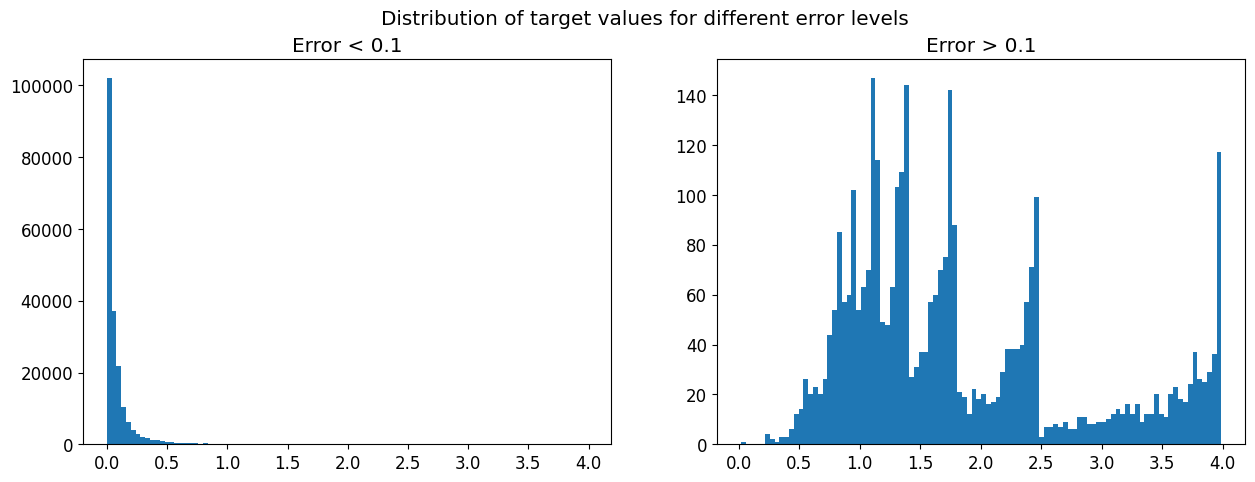

In [20]:
# Plot hist for the ones with error under 0.1 and ones with error higher than 0.1 next to each other in two subplots
plt.rcParams.update({'font.size': 12})
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
axs[0].hist(results_df[results_df["abs_diff"] < 0.1]["target"], bins=100, alpha=1, label="target")
axs[1].hist(results_df[results_df["abs_diff"] > 0.1]["target"], bins=100, alpha=1, label="target")
axs[0].set_title("Error < 0.1")
axs[1].set_title("Error > 0.1")

# Figure title
fig.suptitle("Distribution of target values for different error levels")
# Font size



In [21]:
results2 = eval_loop(dataloader, snn_lin_out, mode="mean", apply_from=int(0.1*num_time_steps_per_sample))
results3 = eval_loop(dataloader, snn_lin_out, mode="mean", apply_from=int(0.2*num_time_steps_per_sample))
results4 = eval_loop(dataloader, snn_lin_out, mode="mean", apply_from=int(0.3*num_time_steps_per_sample))
results5 = eval_loop(dataloader, snn_lin_out, mode="mean", apply_from=int(0.4*num_time_steps_per_sample))
results6 = eval_loop(dataloader, snn_lin_out, mode="mean", apply_from=int(0.5*num_time_steps_per_sample))

results_df2 = pd.DataFrame(results2, columns=["target", "output"])
results_df3 = pd.DataFrame(results3, columns=["target", "output"])
results_df4 = pd.DataFrame(results4, columns=["target", "output"])
results_df5 = pd.DataFrame(results5, columns=["target", "output"])
results_df6 = pd.DataFrame(results6, columns=["target", "output"])

results_df2["abs_diff"] = abs(results_df2["target"] - results_df2["output"])
results_df3["abs_diff"] = abs(results_df3["target"] - results_df3["output"])
results_df4["abs_diff"] = abs(results_df4["target"] - results_df4["output"])
results_df5["abs_diff"] = abs(results_df5["target"] - results_df5["output"])
results_df6["abs_diff"] = abs(results_df6["target"] - results_df6["output"])

print(f"Max error for 0.1: {results_df2['abs_diff'].max()}; mean error: {results_df2['abs_diff'].mean()}")
print(f"Max error for 0.2: {results_df3['abs_diff'].max()}; mean error: {results_df3['abs_diff'].mean()}")
print(f"Max error for 0.3: {results_df4['abs_diff'].max()}; mean error: {results_df4['abs_diff'].mean()}")
print(f"Max error for 0.4: {results_df5['abs_diff'].max()}; mean error: {results_df5['abs_diff'].mean()}")
print(f"Max error for 0.5: {results_df6['abs_diff'].max()}; mean error: {results_df6['abs_diff'].mean()}")

  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/196 [00:00<?, ?it/s]

Max error for 0.1: 0.4456822872161865; mean error: 0.004985988467088678
Max error for 0.2: 0.3651137351989746; mean error: 0.003557121410839312
Max error for 0.3: 0.33171653747558594; mean error: 0.0034421846194219994
Max error for 0.4: 0.3667886257171631; mean error: 0.0036631046158193173
Max error for 0.5: 0.33966851234436035; mean error: 0.0041414462693192345


In [22]:


print(f"MSE for 0.0: {mean_squared_error(results_df['target'], results_df['output'])}")
print(f"MSE for 0.1: {mean_squared_error(results_df2['target'], results_df2['output'])}")
print(f"MSE for 0.2: {mean_squared_error(results_df3['target'], results_df3['output'])}")
print(f"MSE for 0.3: {mean_squared_error(results_df4['target'], results_df4['output'])}")
print(f"MSE for 0.4: {mean_squared_error(results_df5['target'], results_df5['output'])}")
print(f"MSE for 0.5: {mean_squared_error(results_df6['target'], results_df6['output'])}")


print(f"R2 for 0.0: {r2_score(results_df['target'], results_df['output'])}")
print(f"R2 for 0.1: {r2_score(results_df2['target'], results_df2['output'])}")
print(f"R2 for 0.2: {r2_score(results_df3['target'], results_df3['output'])}")
print(f"R2 for 0.3: {r2_score(results_df4['target'], results_df4['output'])}")
print(f"R2 for 0.4: {r2_score(results_df5['target'], results_df5['output'])}")
print(f"R2 for 0.5: {r2_score(results_df6['target'], results_df6['output'])}")

MSE for 0.0: 0.0012375979823318224
MSE for 0.1: 0.00023035085073598238
MSE for 0.2: 0.00012142063694495857
MSE for 0.3: 9.568456975681524e-05
MSE for 0.4: 8.74963460157202e-05
MSE for 0.5: 9.530216279429377e-05
R2 for 0.0: 0.9862600818103111
R2 for 0.1: 0.9974426252391958
R2 for 0.2: 0.9986519777488484
R2 for 0.3: 0.9989377017583714
R2 for 0.4: 0.9990286081156277
R2 for 0.5: 0.9989419472730339


In [23]:
# Save SNN model wit TorchScript to be able to load without class definition
torch.save(snn_lin_out.spiking_model, "snn_lin_out.pt")

In [24]:
# Export to NIR
from sinabs import to_nir, from_nir
from  sinabs.activation.reset_mechanism import MembraneSubtract

nir_model = to_nir(snn_lin_out.spiking_model, test_dataset[0][0], "snn_lin_out")

import norse.torch as norse

norse_model = norse.from_nir(nir_model, reset_method=norse.reset_subtract)

norse_model

GraphExecutor(
  (input): Identity()
  (0): Linear(in_features=3, out_features=256, bias=True)
  (1): IAFCell(
    p=IAFParameters(v_th=tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
            1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
            1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
            1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
            1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
            1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
            1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
            1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
            1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
            1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
            1., 1., 1., 1., 

In [25]:
for name, layer in norse_model.named_children():
    if isinstance(layer, torch.nn.Linear):
        print(name)
        snn_lin_out_weights = snn_lin_out.spiking_model[int(name)].state_dict()['weight']
        snn_lin_out_bias = snn_lin_out.spiking_model[int(name)].state_dict()['bias']
        
        assert torch.allclose(layer.state_dict()['weight'], snn_lin_out_weights), f"Layer {name} weights are not equal"
        assert torch.allclose(layer.state_dict()['bias'], snn_lin_out_bias), f"Layer {name} biases are not equal"

0
2
4
6


In [26]:
batch_1_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False)

results_norse = eval_loop(dataloader, norse_model, is_norse=True)

  0%|          | 0/196 [00:00<?, ?it/s]

Data shape: torch.Size([100, 1024, 3])
torch.Size([100, 1024, 1])
Data shape: torch.Size([100, 1024, 3])
torch.Size([100, 1024, 1])
Data shape: torch.Size([100, 1024, 3])
torch.Size([100, 1024, 1])
Data shape: torch.Size([100, 1024, 3])
torch.Size([100, 1024, 1])
Data shape: torch.Size([100, 1024, 3])
torch.Size([100, 1024, 1])
Data shape: torch.Size([100, 1024, 3])
torch.Size([100, 1024, 1])
Data shape: torch.Size([100, 1024, 3])
torch.Size([100, 1024, 1])
Data shape: torch.Size([100, 1024, 3])
torch.Size([100, 1024, 1])
Data shape: torch.Size([100, 1024, 3])
torch.Size([100, 1024, 1])
Data shape: torch.Size([100, 1024, 3])
torch.Size([100, 1024, 1])
Data shape: torch.Size([100, 1024, 3])
torch.Size([100, 1024, 1])
Data shape: torch.Size([100, 1024, 3])
torch.Size([100, 1024, 1])
Data shape: torch.Size([100, 1024, 3])
torch.Size([100, 1024, 1])
Data shape: torch.Size([100, 1024, 3])
torch.Size([100, 1024, 1])
Data shape: torch.Size([100, 1024, 3])
torch.Size([100, 1024, 1])
Data shape

In [27]:
results_df_norse = pd.DataFrame(results_norse, columns=["target", "output", "model_output"])
results_df_norse["abs_diff"] = abs(results_df_norse["target"] - results_df_norse["output"])
results_df_norse.head()

,target,output,model_output,abs_diff
0,0.036083,0.045391,"[[[tensor(0.0454)], [tensor(0.0454)], [tensor(...",0.009308
1,0.061312,0.045391,"[[[tensor(0.0454)], [tensor(0.0454)], [tensor(...",0.015921
2,0.023691,0.045391,"[[[tensor(0.0454)], [tensor(0.0454)], [tensor(...",0.021700
3,0.622410,0.045391,"[[[tensor(0.0454)], [tensor(0.0454)], [tensor(...",0.577019
4,0.116947,0.045391,"[[[tensor(0.0454)], [tensor(0.0454)], [tensor(...",0.071556


In [28]:
# Metrics
print(f"Max error for norse: {results_df_norse['abs_diff'].max()}; mean error: {results_df_norse['abs_diff'].mean()}")
print(f"MSE for norse: {mean_squared_error(results_df_norse['target'], results_df_norse['output'])}")
print(f"R2 for norse: {r2_score(results_df_norse['target'], results_df_norse['output'])}")

Max error for norse: 3.9440310560166836; mean error: 0.10447808228115227
MSE for norse: 0.09407019632694077
R2 for norse: -0.044375330335329366


# First results
We can see that on average our results are pretty okay with the the mean absolute difference being around 0.01, with some having larger error, specifically those that would have a higher target number anyways reaching an error of up to 0.7.

We can also see that if we give the SNN some time to reach around the target and only take the average of, for example, the second half of the timesteps our results improve again by a good amount.

Most records with small targets also have small error, showing some sort of correlation here.

We want to now see how the outputs look if we were to count spike outputs for each input

In [29]:
from sinabs.activation import MembraneReset, SingleSpike, MultiSpike, MembraneSubtract

snn_spike_out = sinabs.from_model(ann, input_shape=(3,), add_spiking_output=False, synops=False, num_timesteps=num_time_steps_per_sample, spike_threshold=torch.tensor(1),
                                  min_v_mem=-1,
                                  spike_fn=SingleSpike)
snn_spike_out

Network(
  (spiking_model): Sequential(
    (0): Linear(in_features=3, out_features=256, bias=True)
    (1): IAFSqueeze(spike_threshold=Parameter containing:
    tensor(1), min_v_mem=Parameter containing:
    tensor(-1), batch_size=-1, num_timesteps=100)
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): IAFSqueeze(spike_threshold=Parameter containing:
    tensor(1), min_v_mem=Parameter containing:
    tensor(-1), batch_size=-1, num_timesteps=100)
    (4): Linear(in_features=256, out_features=256, bias=True)
    (5): IAFSqueeze(spike_threshold=Parameter containing:
    tensor(1), min_v_mem=Parameter containing:
    tensor(-1), batch_size=-1, num_timesteps=100)
    (6): Linear(in_features=256, out_features=1, bias=True)
  )
  (analog_model): Sequential(
    (0): Linear(in_features=3, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=256, bias=True)
 

In [30]:
results = eval_loop(dataloader, snn_spike_out, mode="count")
results_df_count = pd.DataFrame(results, columns=["target", "count"])

  0%|          | 0/196 [00:00<?, ?it/s]

In [31]:
results_df_count["target/count"] = results_df_count["target"] / results_df_count["count"]

In [32]:
results_df_count.head()

,target,count,target/count
0,0.036083,87,0.000415
1,0.061312,90,0.000681
2,0.023691,87,0.000272
3,0.622410,95,0.006552
4,0.116947,75,0.001559


In [33]:
results_df_count.describe()

,target,count,target/count
count,2.000000e+05,200000.000000,2.000000e+05
mean,1.086131e-01,83.185865,1.311068e-03
std,3.001227e-01,5.622324,3.672853e-03
min,0.000000e+00,42.000000,0.000000e+00
25%,2.247868e-08,80.000000,2.767927e-10
50%,3.664592e-02,84.000000,4.331738e-04
75%,9.494516e-02,87.000000,1.134101e-03
max,3.989422e+00,100.000000,6.770100e-02


In [34]:
results_df_count[results_df_count["count"] == 50].describe()

,target,count,target/count
count,3.700000e+01,37.0,3.700000e+01
mean,2.743700e-03,50.0,5.487400e-05
std,7.334097e-03,0.0,1.466819e-04
min,0.000000e+00,50.0,0.000000e+00
25%,0.000000e+00,50.0,0.000000e+00
50%,3.987227e-13,50.0,7.974454e-15
75%,3.987228e-05,50.0,7.974457e-07
max,2.914367e-02,50.0,5.828734e-04


(array([1.0000e+00, 2.0000e+00, 0.0000e+00, 5.0000e+00, 0.0000e+00,
        9.0000e+00, 1.1000e+01, 0.0000e+00, 1.1000e+01, 0.0000e+00,
        1.2000e+01, 0.0000e+00, 2.1000e+01, 3.7000e+01, 0.0000e+00,
        3.1000e+01, 0.0000e+00, 5.3000e+01, 7.5000e+01, 0.0000e+00,
        8.3000e+01, 0.0000e+00, 1.2200e+02, 0.0000e+00, 1.4100e+02,
        1.6100e+02, 0.0000e+00, 1.8100e+02, 0.0000e+00, 2.0100e+02,
        0.0000e+00, 2.1400e+02, 2.1000e+02, 0.0000e+00, 2.2800e+02,
        0.0000e+00, 2.6000e+02, 2.7200e+02, 0.0000e+00, 2.5700e+02,
        0.0000e+00, 3.1900e+02, 0.0000e+00, 3.0000e+02, 3.7200e+02,
        0.0000e+00, 4.7800e+02, 0.0000e+00, 6.3800e+02, 0.0000e+00,
        8.1400e+02, 1.2170e+03, 0.0000e+00, 1.7130e+03, 0.0000e+00,
        2.2640e+03, 3.2680e+03, 0.0000e+00, 4.6280e+03, 0.0000e+00,
        6.0400e+03, 0.0000e+00, 7.8290e+03, 9.6060e+03, 0.0000e+00,
        1.1470e+04, 0.0000e+00, 1.2970e+04, 1.4761e+04, 0.0000e+00,
        1.5635e+04, 0.0000e+00, 1.6498e+04, 0.00

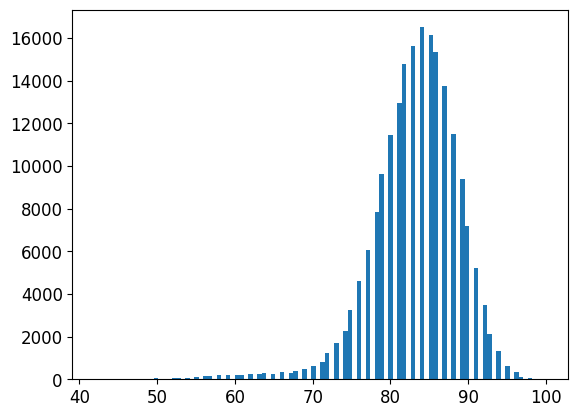

In [35]:
plt.hist(results_df_count["count"], bins=100)

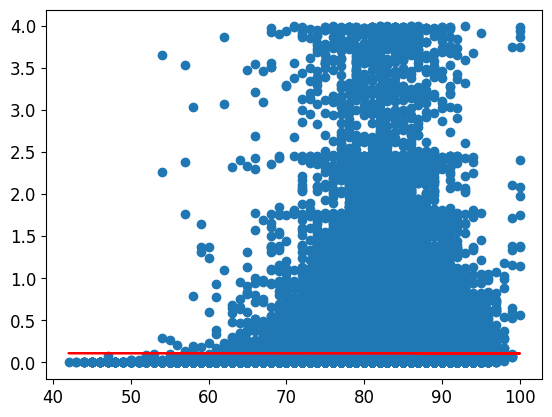

In [36]:
# Plot x as count and y as target

plt.scatter(results_df_count["count"], results_df_count["target"])

# Add regression line
import numpy as np
from sklearn.linear_model import LinearRegression

X = results_df_count["count"].values.reshape(-1, 1)
y = results_df_count["target"].values

reg = LinearRegression().fit(X, y)

plt.plot(X, reg.predict(X), color='red')
